# Import

In [9]:
%%capture
!pip install catboost
!pip install optuna

import pandas as pd
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score

In [20]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
from tqdm import tqdm
tqdm.pandas()

# Load Data

In [2]:
PATH = '/kaggle/input/test-rosatom/aclImdb'

train_data_dir = PATH + '/train'
test_data_dir = PATH + '/test'

In [3]:
def extract_rating(filename):
    return int(filename.split('_')[-1].split('.')[0])

def read_files(file_paths):
    texts = []
    ratings = []
    
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as file:
            texts.append(file.read())
        ratings.append(extract_rating(os.path.basename(file_path)))
    
    return texts, ratings

def read_dataset(data_dir, pn):
    dir_path = os.path.join(data_dir, pn)
    files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith('.txt')]
    texts, ratings = read_files(files)
    return pd.DataFrame({'text': texts, 'rating': ratings})

In [4]:
pos_df = read_dataset(train_data_dir, 'pos')
neg_df = read_dataset(train_data_dir, 'neg')

(array([5100.,    0., 2284.,    0.,    0., 2420.,    0., 2696.]),
 array([1.   , 1.375, 1.75 , 2.125, 2.5  , 2.875, 3.25 , 3.625, 4.   ]),
 <BarContainer object of 8 artists>)

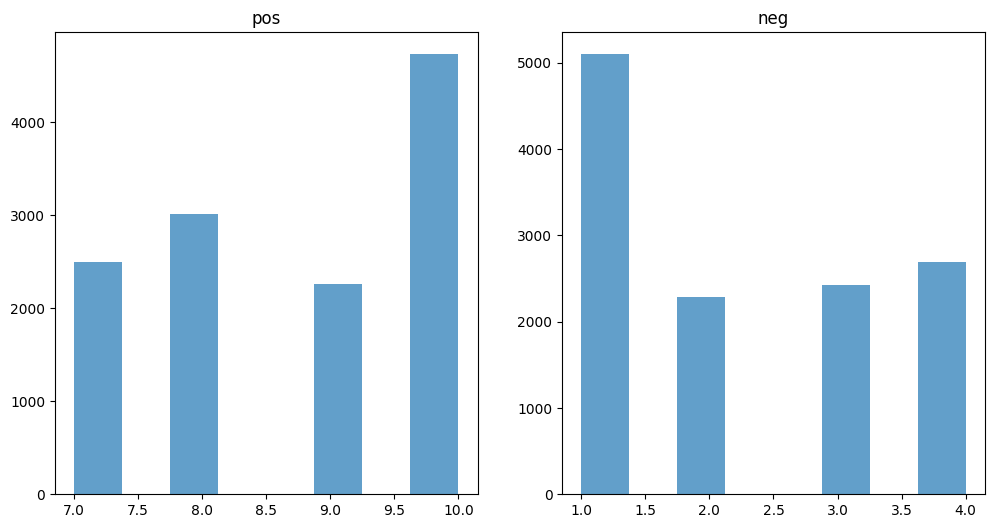

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].set_title('pos')
axs[0].hist(pos_df['rating'], bins=8, alpha=0.7)
axs[1].set_title('neg')
axs[1].hist(neg_df['rating'], bins=8, alpha=0.7)

In [14]:
train_data = pd.concat([pos_df, neg_df], axis=0).reset_index(drop=True)
train_data = train_data.sample(frac=1).reset_index(drop=True)

# Text Preprocessing

## Train Processing 

In [15]:
train_data.iloc[0]['text']

'A story of obsessive love pushed to its limits and of a lovely swan whose beauty is the very ticket to her own premature demise. Placed at the beginning of talkies, PRIX DE BEAUTE walks a thin line in being a full-on silent film -- which is still is at heart -- and flirting with sound and sound effects. The effect is a little irritating for anyone coming into this film because the recorded audio is extremely tinny and just doesn\'t help it at all. Hearing sound stage conversation edited over the beginning sequence which takes place in a beach, for example, is as part of the movie as the actress who dubs Louise Brooks\' dialog and in doing so robs the audience of a fine performance. Other than that, the movie rolls along more or less well, with little jumps in continuity here and there -- something quite common in films from this era -- and has that vague sped up feel typical of silents. In a way, this is an experiment of a movie, and closer to the style of Sergei Eisenstein in visual 

In [16]:
train_data['rating'].value_counts(normalize=True)

rating
1     0.20400
10    0.18928
8     0.12036
4     0.10784
7     0.09984
3     0.09680
2     0.09136
9     0.09052
Name: proportion, dtype: float64

In [17]:
train_data.drop_duplicates()

,text,rating
0,A story of obsessive love pushed to its limits...,8
1,Christopher Lee is one of my favorite actors! ...,1
2,The movie is a fantasy. The story line is thin...,10
3,Kate Beckinsale is as good if not better than ...,8
4,I watched this movie on the grounds that Amber...,4
...,...,...
24995,"If the movies are to be believed, Chinese ghos...",7
24996,"Seldom seen since theatrical release in 1970, ...",3
24997,Where to begin? the special effects should be ...,1
24998,Jon Voight plays a man named Joe. Joe is shook...,10


In [18]:
def preprocess_text(text):
    text = text.replace('<br />', '')
    text = text.lower()
    text = re.sub("@\w+", '', text)
    text = re.sub("http\w+", '', text)
    text = re.sub("\d+", '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.strip()
    stemmer = PorterStemmer()
    tokens = WordPunctTokenizer().tokenize(text)
    stemmed_words = ' '.join([stemmer.stem(word) for word in tokens])

    return stemmed_words

In [21]:
preprocess_text(train_data.iloc[0]['text'])

'a stori of obsess love push to it limit and of a love swan whose beauti is the veri ticket to her own prematur demis place at the begin of talki prix de beaut walk a thin line in be a fullon silent film which is still is at heart and flirt with sound and sound effect the effect is a littl irrit for anyon come into thi film becaus the record audio is extrem tinni and just doesnt help it at all hear sound stage convers edit over the begin sequenc which take place in a beach for exampl is as part of the movi as the actress who dub louis brook dialog and in do so rob the audienc of a fine perform other than that the movi roll along more or less well with littl jump in continu here and there someth quit common in film from thi era and ha that vagu sped up feel typic of silent in a way thi is an experi of a movi and closer to the style of sergei eisenstein in visual present and nearintim closeup that elev it from what would be a more pedestrian level louis brook here play a charact less fla

In [28]:
train_data['text'] = train_data['text'].apply(preprocess_text)

In [29]:
train_data.isna().sum()

text      0
rating    0
dtype: int64

In [36]:
train_data.to_csv('train_csv.csv', index=False)

In [39]:
train_data.head()

,text,rating
0,a stori of obsess love push to it limit and of...,8
1,christoph lee is one of my favorit actor im tr...,1
2,the movi is a fantasi the stori line is thin b...,10
3,kate beckinsal is as good if not better than g...,8
4,i watch thi movi on the ground that amber bens...,4


## Test Processing

In [30]:
pos_df_test = read_dataset(test_data_dir, 'pos')
neg_df_test = read_dataset(test_data_dir, 'neg')

test_data = pd.concat([pos_df_test, neg_df_test], axis=0).reset_index(drop=True)
test_data = train_data.sample(frac=1).reset_index(drop=True)

test_data['text'] = test_data['text'].apply(preprocess_text)

In [38]:
test_data.to_csv('test_data.csv', index=False)

# Baseline

## 1) CatBoost

In [264]:
X_train, X_test, y_train, y_test = train_test_split(train_data['text'], train_data['rating'], test_size=0.3)

In [16]:
X_train = pd.DataFrame({'text': X_train})
X_test = pd.DataFrame({'text': X_test})

In [ ]:
model_cb = CatBoostClassifier(random_state=42)
model_cb.fit(X_train, y_train, text_features=['text'], verbose=True)

In [184]:
pred = model_cb.predict(X_test)

In [185]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       0.58      0.81      0.68      1531
           2       0.43      0.15      0.22       694
           3       0.32      0.21      0.25       731
           4       0.39      0.46      0.42       790
           7       0.42      0.34      0.37       764
           8       0.35      0.36      0.36       881
           9       0.46      0.13      0.20       714
          10       0.51      0.74      0.61      1395

    accuracy                           0.47      7500
   macro avg       0.43      0.40      0.39      7500
weighted avg       0.45      0.47      0.44      7500



In [186]:
roc_auc_score(y_test, model_cb.predict_proba(X_test), multi_class='ovr')

0.846324953918915

In [ ]:
def objective(trial):

    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
#         'border_count': trial.suggest_int('border_count', 32, 255),
#         'random_strength': trial.suggest_float('random_strength', 1e-3, 10, log=True),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'task_type': 'GPU',
        'devices': '0', 
    }
    model = CatBoostClassifier(**params, verbose=0, text_features=['text'], random_state=42)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=False)

    preds = model.predict(X_test)
    f1 = f1_score(y_test, preds, average='macro')

    return f1
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, timeout=600)  # n_trials - количество испытаний, timeout - максимальное время оптимизации в секундах

print("Best trial:")
trial = study.best_trial

print("  F1-score: {}".format(trial.value))
print("  Best hyperparameters: {}".format(trial.params))

[I 2024-10-07 18:17:27,812] A new study created in memory with name: no-name-9da0831d-4b70-4530-a6ee-44f91f2c98db
[I 2024-10-07 18:17:40,277] Trial 0 finished with value: 0.3737444360936561 and parameters: {'iterations': 410, 'learning_rate': 0.0940452369851627, 'depth': 7, 'l2_leaf_reg': 0.8825747109228478}. Best is trial 0 with value: 0.3737444360936561.


# Эксперименты в рамках работы
1. Катбуст со стеммингом - стоп-слова -- тест -- 0.833
2. Катбуст со стеммингом + стоп-слова -- тест -- 0.844 

# RandomForest + TF-IDF

In [137]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (17500, 1)
y_train shape: (17500,)


In [176]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(random_state=42)
vec1 = TfidfVectorizer(max_features=10000, ngram_range=(1,3))

In [177]:
pipe1 = Pipeline([('vectorizer_', vec1), ('model_', model_rf)])

pipe1.fit(X_train['text'], y_train)

Pipeline(steps=[('vectorizer_',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 3))),
                ('model_', RandomForestClassifier(random_state=42))])

In [178]:
y_pred = pipe1.predict(X_test['text']) 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.41      0.86      0.55      1510
           2       0.47      0.01      0.03       656
           3       0.26      0.02      0.03       775
           4       0.31      0.09      0.13       809
           7       0.28      0.10      0.15       715
           8       0.27      0.13      0.17       924
           9       0.25      0.01      0.02       699
          10       0.36      0.83      0.50      1412

    accuracy                           0.37      7500
   macro avg       0.33      0.26      0.20      7500
weighted avg       0.33      0.37      0.26      7500

